## UGCA Project 1 Report
By Fan Hong, Ting-Yi Hung, Abhilasha Kanitkar, Brian Peterson  

We scraped all the comments in all the forums under the tires and wheels section of edmunds (42,890 comments)  
https://forums.edmunds.com/discussions/tagged/x/tires-wheels

## Import and clean data

In [7]:
import json
import nltk
from nltk.tokenize import word_tokenize,sent_tokenize
from functools import reduce
from collections import Counter

with open("edmunds_comment_data.json", 'r') as f:
    js = json.load(f)

commentcount = 0
characterstoclean = r'?!,:,/\"-+=@#$%^&*()><{}[]|' + r"'"

commentsdict = {}
words = []
for i in js.keys():
    for j in js[i].keys():
        for k in js[i][j].keys():
            for l in js[i][j][k].keys():
                commentcount+=1
                cleanwords = []
#                 for w in word_tokenize(js[i][j][k][l]):
#                     cleanword = ''.join( c for c in w if c not in characterstoclean ).lower()
#                     cleanwords.append(cleanword)
#                     words.append(cleanword)
                comment = ''
                # to remove quoted content in comments, not 100% effective
                for s in sent_tokenize(js[i][j][k][l].lower()):
                    if "said:" not in s:
                        comment+=" " + s
                for c in characterstoclean:
                    comment = comment.replace(c,'')
                for w in word_tokenize(comment):
                    cleanwords.append(w)
                    words.append(w)                
                
                commentsdict['comment' + str(commentcount)] = ' '.join(cleanwords)
                

print("Number of comments scraped: " + str(commentcount))

Number of comments scraped: 42890


## Top 10 most frequently used words

In [8]:
cnt = Counter(words)

In [39]:
from nltk.corpus import stopwords
from nltk.corpus import brown
stopwords_set = set(stopwords.words('english'))
brown_set = set(brown.words())

In [49]:
ranked_cnt = []
for i in cnt:
    if i not in stopwords_set and i not in characterstoclean and i != '.' and i != '...' :
        ranked_cnt.append( (cnt[i], i) )
ranked_cnt.sort(reverse=True)

for i in range(len(ranked_cnt[:10])):
    print(str(i+1) + ") '" + str(ranked_cnt[i][1]) + "' appeared " + str(ranked_cnt[i][0]) + ' times')

1) 'tires' appeared 23827 times
2) 'tire' appeared 16121 times
3) 'car' appeared 9481 times
4) 'would' appeared 8370 times
5) 'new' appeared 6485 times
6) 'get' appeared 6235 times
7) 'miles' appeared 5916 times
8) 'like' appeared 5771 times
9) 'one' appeared 5637 times
10) 'good' appeared 5113 times


Note: we removed stopwords from the above list

## Top 10 Mentioned Brands

In [72]:
brands = ['BFGoodrich', 'Bridgestone', 'Continental', 'Cooper', 'Dunlop', 'Falken', 'Firestone', 'General', 'Goodyear', 'GT Radial', 'Hankook', 'Kumho', 'Michelin', 'Nexen', 'Nitto', 'Nokian', 'Pirelli', 'Sumitomo', 'Toyo', 'Uniroyal', 'Yokohama']
brand_counts = []
for i in brands:
    brand_counts.append((i, cnt[i.lower()] ))

brand_counts.sort(key=lambda x: x[1], reverse=True)

for i in range(len(brand_counts[:10])):
    print(str(i+1) + ") the brand '" + str(brand_counts[i][0]) + "' was mentioned " + str(brand_counts[i][1]) + ' times')

1) the brand 'Michelin' was mentioned 2579 times
2) the brand 'Bridgestone' was mentioned 1533 times
3) the brand 'Goodyear' was mentioned 1358 times
4) the brand 'Toyo' was mentioned 622 times
5) the brand 'Firestone' was mentioned 531 times
6) the brand 'Dunlop' was mentioned 499 times
7) the brand 'Continental' was mentioned 450 times
8) the brand 'Yokohama' was mentioned 441 times
9) the brand 'General' was mentioned 398 times
10) the brand 'Nokian' was mentioned 350 times


### TASK A: Find lift values for brands

#### 1) For each brand, find the number of comments that mention it 

In [163]:
brands = {'BFGoodrich', 'Bridgestone', 'Continental', 'Cooper', 'Dunlop', 'Falken', 'Firestone', 'General', 'Goodyear', 'Hankook', 'Kumho', 'Michelin', 'Nexen', 'Nitto', 'Nokian', 'Pirelli', 'Sumitomo', 'Toyo', 'Uniroyal', 'Yokohama'}
brands = list(map(lambda x: x.lower(), brands))
brand_mention = dict()

#initialize counter
for i in brands:
    brand_mention[i] = dict()
    
for i in brands:
    for j in commentsdict:
        for k in word_tokenize(commentsdict[j]):
            if k == i:
                brand_mention[i][j] = commentsdict[j]
                break


In [164]:
brand_mention_list = []
for i in brand_mention:
    brand_mention_list.append( (i, len(brand_mention[i])))
brand_mention_list.sort(key=lambda x: x[1], reverse=True)

In [166]:
for i in range(len(brand_mention_list[:10])):
    print(str(i+1) + ") The brand '" + str(brand_mention_list[i][0].title(),) + "' was mentioned " + str(brand_mention_list[i][1]) + ' times')

1) The brand 'Michelin' was mentioned 2097 times
2) The brand 'Bridgestone' was mentioned 1336 times
3) The brand 'Goodyear' was mentioned 1147 times
4) The brand 'Toyo' was mentioned 451 times
5) The brand 'Dunlop' was mentioned 447 times
6) The brand 'Firestone' was mentioned 435 times
7) The brand 'Continental' was mentioned 399 times
8) The brand 'Yokohama' was mentioned 387 times
9) The brand 'General' was mentioned 376 times
10) The brand 'Pirelli' was mentioned 314 times


#### 2) Calculate Lift Values

In [167]:
# first we need to find the number of messages containing each pair of brands

# for each brand mentioned, find number of times the another brand was also mentioned
cross_brand = dict()

# init dictionary
for i in brand_mention:
    cross_brand[i] = dict()
    for j in brand_mention:
        cross_brand[i][j] = dict() 

for i in brands:
    for j in brand_mention:
        for k in brand_mention[j]:
            for l in word_tokenize(brand_mention[j][k]):
                if l == i:
                    cross_brand[i][j][k] = brand_mention[j][k]
                    break
        

In [168]:
# pick two brands and you can use this dictionary to find the comments that have both in it
cross_brand['nitto']['michelin']

{'comment10859': 'ive got a 2009 limited and am looking for the 3rd set of tires . the oem toyos were the only option when the car was new . they lasted about 60k miles but had poor wet traction even when new . the next set wereare nitto crosstek cuv . they are at the wear bars now at 51k miles . these have a slightly harsher ride than the toyos but pretty good traction for wet and dry . i may replace with the same nitto tire however im curious if anyone has used michelin latitude tour hp long enough for a review ...',
 'comment11054': 'unusual wear on the tires ... auto manufacturers need to sell their cars with tires that are unlikely to cup . all cars have funky amounts of camber and toe which causes tires to cup . the nitto motivos you guys took off the charger are pretty good at not cupping as are michelin primacy mxv4s and pilot sport as 3s . i cant believe they equip their cars with the garbage goodyear ls2 tires .'}

In [ ]:
total_comments = len(commentsdict)

In [191]:
# now we can calculate the lift value
data=[]
for i in range(len(cross_brand.keys())):
    row = []
    for j in range(len(cross_brand[list(cross_brand.keys())[i]].keys())):
        if j > i:
            row.append(round( len(cross_brand[list(cross_brand.keys())[i]][list(cross_brand.keys())[j]])\
                             / (len(brand_mention[list(cross_brand.keys())[i]])\
                                * len(brand_mention[list(cross_brand.keys())[j]]) ) * total_comments, 4))
        else:
            row.append('')
    data.append(row)

In [192]:
lift_chart = pd.DataFrame(data, columns=cross_brand.keys(), index=cross_brand.keys())

In [194]:
print("Lift Values")
lift_chart

Lift Values


,cooper,bridgestone,goodyear,nokian,general,hankook,falken,michelin,dunlop,yokohama,nitto,nexen,sumitomo,firestone,uniroyal,continental,pirelli,toyo,kumho,bfgoodrich
cooper,,3.4964,3.3321,3.0117,4.5176,6.3858,2.6877,2.2276,5.7,3.2919,0,0,7.864,3.4168,9.6512,2.6607,6.762,1.8832,5.4443,3.7915
bridgestone,,,3.1907,1.8215,1.9638,2.6552,3.6573,4.1947,4.5964,3.7329,1.0032,0,1.7835,5.5351,3.6481,7.2413,5.112,4.1998,2.9399,2.8664
goodyear,,,,1.8564,2.4862,4.4984,1.8933,3.8517,4.35,4.348,2.3371,6.5988,5.5397,4.0402,4.2492,1.9681,3.8108,2.4044,2.7394,6.6774
nokian,,,,,1.618,1.1436,0,1.5956,3.0623,1.572,0,0,2.8165,1.0489,0,0.7624,2.4219,1.3489,0.5571,0
general,,,,,,1.7153,4.3317,2.339,2.0415,2.6528,3.5647,0,8.4496,3.9334,7.7774,2.573,5.8124,2.0234,5.8497,8.1478
hankook,,,,,,,4.082,3.8446,2.1643,4.9997,0,0,11.9437,2.224,7.3291,4.8493,6.1621,8.5804,11.8125,5.7586
falken,,,,,,,,3.1068,7.2874,9.8201,33.932,0,10.0539,1.2481,12.3389,1.3607,3.458,8.4266,5.9661,9.6948
michelin,,,,,,,,,4.2096,4.1223,1.2783,3.6094,2.6513,2.7741,3.2539,2.7681,4.755,2.721,2.9968,4.3828
dunlop,,,,,,,,,,6.6942,2.9985,0,23.0993,3.7498,4.3614,2.4048,8.8617,2.9785,3.5147,1.7134
yokohama,,,,,,,,,,,0,0,12.3141,2.293,5.0376,2.2221,9.1767,2.9488,4.8715,9.8953


#### 3) Graph MDS Chart

In [243]:
# now we can calculate the lift value
data=[]
for i in range(len(cross_brand.keys())):
    row = []
    for j in range(len(cross_brand[list(cross_brand.keys())[i]].keys())):
            row.append(round( len(cross_brand[list(cross_brand.keys())[i]][list(cross_brand.keys())[j]])\
                             / (len(brand_mention[list(cross_brand.keys())[i]])\
                                * len(brand_mention[list(cross_brand.keys())[j]]) ) * total_comments, 4))
    data.append(row)

In [245]:
similarity_matrix = pd.DataFrame(data, columns=cross_brand.keys(), index=cross_brand.keys())

In [246]:
disimilarity_matrix = similarity_matrix.apply(lambda x: 1/x)

In [248]:
disimilarity_matrix

,cooper,bridgestone,goodyear,nokian,general,hankook,falken,michelin,dunlop,yokohama,nitto,nexen,sumitomo,firestone,uniroyal,continental,pirelli,toyo,kumho,bfgoodrich
cooper,0.004710,0.286008,0.300111,0.332038,0.221356,0.156597,0.372065,0.448914,0.175439,0.303776,inf,inf,0.127162,0.292672,0.103614,0.375841,0.147885,0.531011,0.183678,0.263748
bridgestone,0.286008,0.031149,0.313411,0.548998,0.509217,0.376619,0.273426,0.238396,0.217562,0.267888,0.996810,inf,0.560695,0.180665,0.274115,0.138097,0.195618,0.238107,0.340148,0.348870
goodyear,0.300111,0.313411,0.026743,0.538677,0.402220,0.222301,0.528178,0.259626,0.229885,0.229991,0.427881,0.151543,0.180515,0.247512,0.235338,0.508104,0.262412,0.415904,0.365043,0.149759
nokian,0.332038,0.548998,0.538677,0.006575,0.618047,0.874432,inf,0.626723,0.326552,0.636132,inf,inf,0.355051,0.953380,inf,1.311647,0.412899,0.741345,1.795010,inf
general,0.221356,0.509217,0.402220,0.618047,0.008767,0.582988,0.230856,0.427533,0.489836,0.376960,0.280529,inf,0.118349,0.254233,0.128578,0.388651,0.172046,0.494218,0.170949,0.122733
hankook,0.156597,0.376619,0.222301,0.874432,0.582988,0.003101,0.244978,0.260105,0.462043,0.200012,inf,inf,0.083726,0.449640,0.136442,0.206215,0.162282,0.116545,0.084656,0.173653
falken,0.372065,0.273426,0.528178,inf,0.230856,0.244978,0.001842,0.321875,0.137223,0.101832,0.029471,inf,0.099464,0.801218,0.081045,0.734916,0.289184,0.118672,0.167614,0.103148
michelin,0.448914,0.238396,0.259626,0.626723,0.427533,0.260105,0.321875,0.048893,0.237552,0.242583,0.782289,0.277054,0.377173,0.360477,0.307324,0.361259,0.210305,0.367512,0.333689,0.228165
dunlop,0.175439,0.217562,0.229885,0.326552,0.489836,0.462043,0.137223,0.237552,0.010422,0.149383,0.333500,inf,0.043291,0.266681,0.229284,0.415835,0.112845,0.335739,0.284519,0.583635
yokohama,0.303776,0.267888,0.229991,0.636132,0.376960,0.200012,0.101832,0.242583,0.149383,0.009023,inf,inf,0.081208,0.436110,0.198507,0.450025,0.108972,0.339121,0.205276,0.101058


In [255]:
from sklearn.manifold import MDS
from matplotlib import pyplot as plt

In [269]:
mds = MDS()

In [270]:
mds_coordinates = pd.DataFrame(mds.fit_transform(disimilarity_matrix)) 

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

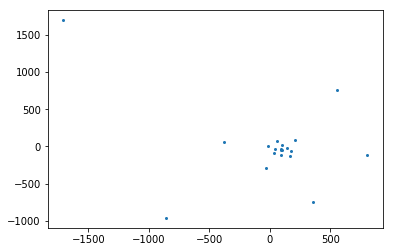

In [267]:
plt.scatter(mds_coordinates[0], mds_coordinates[1], s=4)
plt.show()

## Get all the comments that mention goodyear

In [11]:

goodyear_comments = {}
for i in commentsdict:
    if 'goodyear' in commentsdict[i]:
        goodyear_comments[i] = commentsdict[i]

In [12]:
len(goodyear_comments)

1381

## Get all the words used in comments that mention goodyear

In [13]:
words_in_goodyear_comments = []
for i in goodyear_comments:
    for j in word_tokenize(goodyear_comments[i]):
        words_in_goodyear_comments.append(j)

In [14]:
gdyr_cnt = Counter(words_in_goodyear_comments)

In [56]:
ranked_goyr_cnt = []
for i in gdyr_cnt:
    if i not in stopwords_set and i not in characterstoclean and i != '.' and i != '...' and i not in 'goodyears':
        ranked_goyr_cnt.append( (gdyr_cnt[i], i) )
ranked_goyr_cnt.sort(reverse=True)
ranked_goyr_cnt[:10]

[(2043, 'tires'),
 (1112, 'tire'),
 (516, 'miles'),
 (394, 'car'),
 (386, 'new'),
 (355, 'would'),
 (313, 'michelin'),
 (311, 'like'),
 (291, 'get'),
 (285, 'set')]

## Comments with goodyear and ____ in them

In [16]:
comparisonstring = 'american'

comments_with_gdyr_and = []
for i in goodyear_comments:
    if comparisonstring in goodyear_comments[i]:
        comments_with_gdyr_and.append(goodyear_comments[i])
len(comments_with_gdyr_and)

8

In [26]:
comments_with_gdyr_and[0]

'hey thanks for your response . i did have them install 2 new goodyear tires to replace the 2 that i had just purchased and they are just as bad . the goodyears that i have are called american eagles . is that a private labled model maybe i would be better off going to a different walmart maybe they carry a different tire for my car . maybe they have technicians that are nice . maybe just maybe .'

Possibly filter lift value to represent associations within a maximum word count  
    Beto -- Healthcare (no more than 6 words in between)  
mds map a disimilarity matrix, not similarity matrix